## 1-Importing and Exploring the data
### -Importing libraries
### -Missing values
### -Dropping null values
### -Duplicate rows
### -Number of unique values for each feature
### -Customers from each country
#### --Correcting some coutry names
### -Number of invoices per country
### -Total revenue per country
### -Negetive quantities
#### --cancelled invoices
### -Time features
## 2-Recency-Monetary-Frequency (RMF) analysis
### -Creating recency dataframe
### -Creating monetary dataframe
### -Creating frequency dataframe
### -Creating RFM dataframe
## 3-Creating product categories
### -Keywords occurances in the product descriptions
### -Product description word cloud
### -Creating keyword feaures
### -Clustering description keywords
#### --SVD
#### --PCA
### -KMeans clustering of description keywords
#### --TSNE visualization of keyword clusters
### 4-Categorizing customers based on RMF and products purchased
### -Intermediate datasets
### -Final customer ID dataset consisting of RMF features and product category features
### -Clustering customer ID dataset
#### --Removing outliers for better clustering
#### --Clustering after outlier removal
#### --TSNE visualization of customer clusters
### -Visualizing customer clusters
### -Classification algorithms to predict new customer cluster
#### --Splitting data into training and test sets
#### --Logistic regression
### --SGD
#### --SVC
#### --Random Forest
#### --Stacking classifiers

# Importing and exploring the data

### Importing libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
from plotly.offline import iplot

import random 
import datetime as dt


import nltk, warnings
from nltk.tokenize import  word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler, Normalizer

from sklearn.cluster import KMeans
from sklearn.metrics import  silhouette_score

from sklearn.model_selection import GridSearchCV, learning_curve

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from mlxtend.classifier import StackingClassifier


warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('seaborn-dark-palette')

In [2]:
data = pd.read_csv("data.csv", encoding="ISO-8859-1")

In [3]:
data.shape

(541909, 8)

In [4]:
data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Missing values

In [6]:
data.isnull().mean()

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

In [7]:
null_data=data[data.isnull().any(axis=1)]

In [8]:
null_data.shape

(135080, 8)

In [9]:
null_data.shape[0]/data.shape[0]

0.249266943342886

### Dropping null values 

In [10]:
data = data.dropna()

In [11]:
data.shape

(406829, 8)

### Duplicate rows

In [12]:
duplicated_data=data[data.duplicated()]
print('number of duplicate rows: %d' %duplicated_data.shape[0])

number of duplicate rows: 5225


In [13]:
data.drop_duplicates()
data.shape

(406829, 8)

### Number of unique values for each feature

In [14]:
data.nunique()

InvoiceNo      22190
StockCode       3684
Description     3896
Quantity         436
InvoiceDate    20460
UnitPrice        620
CustomerID      4372
Country           37
dtype: int64

### Customers from each coutry

In [15]:
customer_per_country=data.groupby(['Country'])['CustomerID'].nunique().sort_values( ascending=False)
customer_per_country

Country
United Kingdom          3950
Germany                   95
France                    87
Spain                     31
Belgium                   25
Switzerland               21
Portugal                  19
Italy                     15
Finland                   12
Austria                   11
Norway                    10
Channel Islands            9
Denmark                    9
Australia                  9
Netherlands                9
Cyprus                     8
Japan                      8
Sweden                     8
Poland                     6
Unspecified                4
Israel                     4
Greece                     4
USA                        4
Canada                     4
EIRE                       3
United Arab Emirates       2
Bahrain                    2
Malta                      2
Czech Republic             1
Singapore                  1
Lithuania                  1
Saudi Arabia               1
Brazil                     1
RSA                        1
Icelan

#### Changing "Eire" to "Ireland" and "RSA" to "South Africa"

In [16]:
data['Country']=data['Country'].replace({'EIRE':'Ireland'})
data['Country']=data['Country'].replace({'RSA':'South Africa'})

#### Number of Invoices per country

In [17]:
Invoices_per_country = data['Country'].value_counts()
Invoices_per_country

United Kingdom          361878
Germany                   9495
France                    8491
Ireland                   7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
South Africa                58
Lebanon                     45
Lithuani

#### Total revenue per country

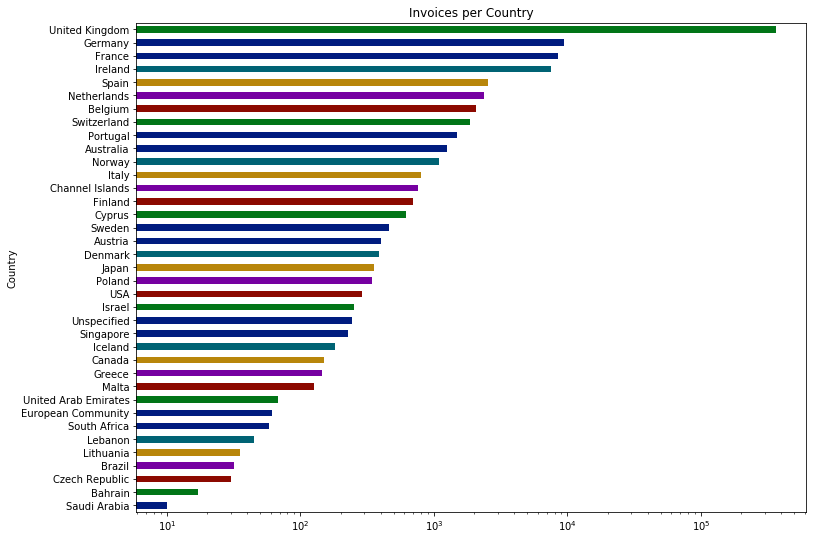

In [18]:
invoices_per_country = data.groupby(["Country"])["InvoiceNo"].count().sort_values(ascending=True)
plt.figure(figsize=(12,9))
invoices_per_country.plot(kind='barh', logx=True)
plt.title("Invoices per Country")
plt.show()

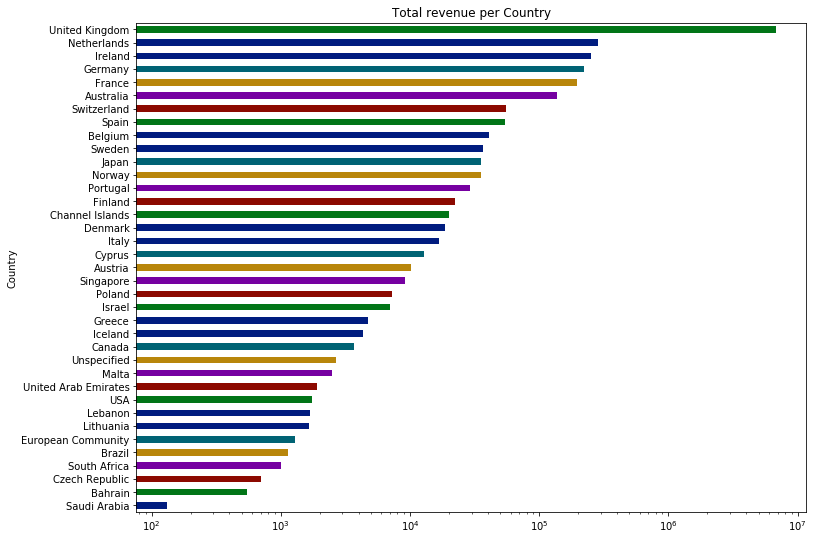

In [19]:
data['TotalPrice']=data['UnitPrice']*data['Quantity']
revenue_per_country=data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=True)
plt.figure(figsize=(12,9))
revenue_per_country.plot(kind='barh', logx=True)
plt.title("Total revenue per Country")
plt.show()

In [20]:
country_invoices = [ dict(
        type = 'choropleth',
        colorscale = 'Blues',
        autocolorscale=False,
        reversescale=True,
        locations = revenue_per_country .index,
        locationmode = 'country names',
        z = np.log10(revenue_per_country),
        text = revenue_per_country.index,
 
        colorbar = dict(
            title = 'Revenue (log10)', 
            titlefont=dict(size=16),
            tickfont=dict(size=12))
      )]
 
# Define layout
layout = dict(
    title = 'Total revenue per country (log10)',
    titlefont = dict(size=24),

    geo = dict(
        showframe = True,
        showcoastlines = True,
        projection = 'equirectangular'
              )
             )
 
# Plot

fig = dict( data=country_invoices, layout=layout )

iplot(fig, validate=False)

### Negetive quantities

In [21]:
data.describe()

,Quantity,UnitPrice,CustomerID,TotalPrice
count,406829.000000,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570,20.401854
std,248.693370,69.315162,1713.600303,427.591718
min,-80995.000000,0.000000,12346.000000,-168469.600000
25%,2.000000,1.250000,13953.000000,4.200000
50%,5.000000,1.950000,15152.000000,11.100000
75%,12.000000,3.750000,16791.000000,19.500000
max,80995.000000,38970.000000,18287.000000,168469.600000


In [22]:
data[data['Quantity']<=0].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,-6.96


#### Cancelled invoices

In [23]:
c_invoices=data[data.InvoiceNo.apply(lambda x:'C' in x)]

In [24]:
c_invoices.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,-6.96


In [25]:
c_invoices.shape[0]/data[data['Quantity']<=0].shape[0]

1.0

This verifies that each item with "C" in invoiceNo has quantity less than zero. This means "C" represenst cancelled items

In [26]:
c_invoices.shape[0]/data.shape[0]

0.021888803403887137

21% of invoices were canceleld! we will remove these

In [27]:
data = data[data.Quantity >0]

In [28]:
print('Number of invoices after cancelled invoices removed: %d' %data.shape[0]) 

Number of invoices after cancelled invoices removed: 397924


### Time features

In [29]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [30]:
data['yearmonth'] = data['InvoiceDate'].apply(lambda x: (100*x.year) + x.month)
data['Week'] = data['InvoiceDate'].apply(lambda x: x.strftime('%W'))
data['day'] = data['InvoiceDate'].apply(lambda x: x.strftime('%d'))
data['Weekday'] = data['InvoiceDate'].apply(lambda x: x.strftime('%w'))
data['hour'] = data['InvoiceDate'].apply(lambda x: x.strftime('%H'))

In [31]:
# 2010-12 Dataset end at
data.loc[data['yearmonth'] == 201012]['InvoiceDate'].max()

Timestamp('2010-12-23 16:06:00')

In [32]:
# 2011-12 Dataset end at
data.loc[data['yearmonth'] == 201112]['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

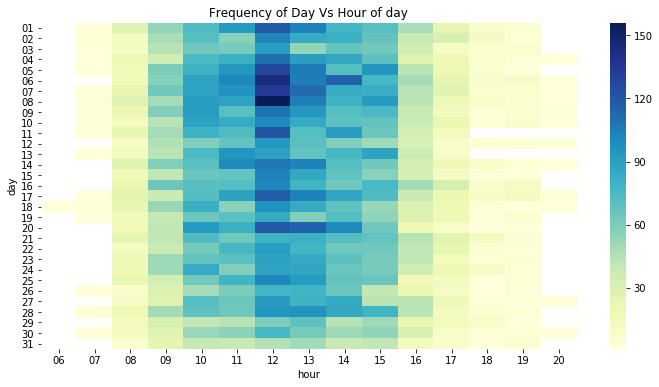

In [33]:
grouped_df  = data.groupby(["day", "hour"])["InvoiceNo"].unique().reset_index()
grouped_df["InvoiceNo"] = grouped_df["InvoiceNo"].apply(len)

#grouped_df = df.groupby(["Weekday", "hour"])["InvoiceNo"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('day', 'hour', 'InvoiceNo')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df , cmap="YlGnBu")
plt.title("Frequency of Day Vs Hour of day")
plt.show()

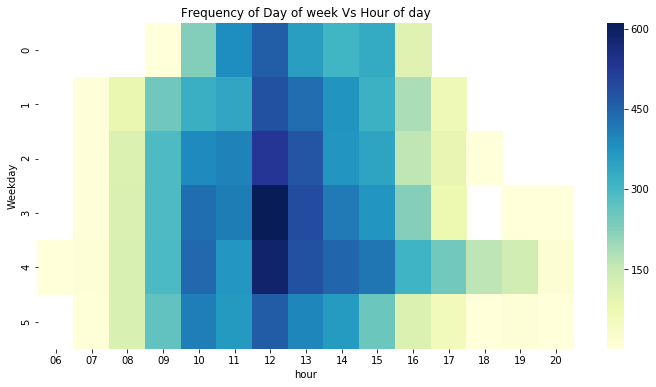

In [34]:
grouped_df  = data.groupby(["Weekday", "hour"])["InvoiceNo"].unique().reset_index()
grouped_df["InvoiceNo"] = grouped_df["InvoiceNo"].apply(len)

#grouped_df = df.groupby(["Weekday", "hour"])["InvoiceNo"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('Weekday', 'hour', 'InvoiceNo')


plt.figure(figsize=(12,6))

sns.heatmap(grouped_df , cmap="YlGnBu" )
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

# 2-Recency-Monetary-Frequency (RMF) analysis

In [35]:
now = dt.date(2011,12,9)

In [36]:
data_rmf=data

In [37]:
data_rmf['date'] = pd.DatetimeIndex(data_rmf.InvoiceDate).date

In [38]:
data_rmf.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,yearmonth,Week,day,Weekday,hour,date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,201012,48,01,3,08,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,201012,48,01,3,08,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,201012,48,01,3,08,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,201012,48,01,3,08,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,201012,48,01,3,08,2010-12-01


### Creating recency dataframe

In [39]:
recency_df = data_rmf.groupby(['CustomerID'],as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurchaseDate']
recency_df.head()

,CustomerID,LastPurchaseDate
0,12346.0,2011-01-18
1,12347.0,2011-12-07
2,12348.0,2011-09-25
3,12349.0,2011-11-21
4,12350.0,2011-02-02


In [40]:
recency_df['Recency'] = recency_df.LastPurchaseDate.apply(lambda x : (now - x).days)

In [41]:
recency_df.head()

,CustomerID,LastPurchaseDate,Recency
0,12346.0,2011-01-18,325
1,12347.0,2011-12-07,2
2,12348.0,2011-09-25,75
3,12349.0,2011-11-21,18
4,12350.0,2011-02-02,310


In [42]:
recency_df.drop(columns=['LastPurchaseDate'],inplace=True)

### Creating monetary dataframe

In [43]:
data_rmf['Total_cost'] = data_rmf['UnitPrice'] * data_rmf['Quantity']
monetary_df=data_rmf.groupby('CustomerID',as_index=False)['Total_cost'].sum()
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()### Creating frequency dataframe

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


### Creating frequency dataframe

In [44]:
frequency_df = data_rmf.groupby('CustomerID',as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


### Creating RFM dataframe

In [45]:
rf_df = recency_df.merge(frequency_df,left_on='CustomerID',right_on='CustomerID')

#combibe rf frame with monetary values..

rfm_df = rf_df.merge(monetary_df,left_on='CustomerID',right_on='CustomerID')

rfm_df.set_index('CustomerID',inplace=True)

In [46]:
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40


In [47]:
rfm_df=rfm_df[rfm_df.Monetary>1]

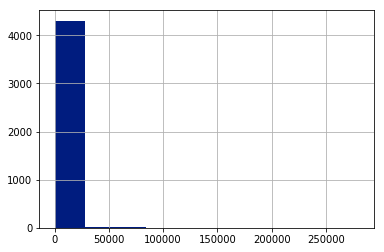

In [48]:
rfm_df.Monetary.hist()

In [49]:
rfm_df=rfm_df[rfm_df.Monetary<75000]

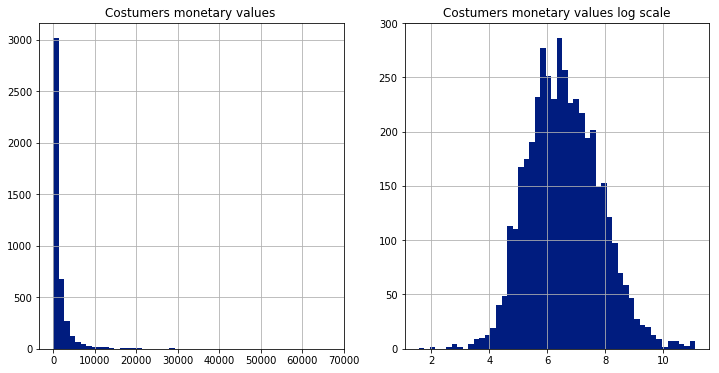

In [50]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
rfm_df.Monetary.hist(ax=ax1, bins=50)

ax2 = fig.add_subplot(122)
np.log1p(rfm_df.Monetary).hist(ax=ax2, bins=50)


ax1.title.set_text('customers monetary values ')
ax2.title.set_text('customers monetary values log scale')

plt.show()

In [51]:
rfm_df.Monetary=np.log1p(rfm_df.Monetary)

# 3-Creating product categories

In [52]:
data['Description']=data['Description'].str.lower()
descriptions=data['Description'].unique()
print(descriptions[:5])

['white hanging heart t-light holder' 'white metal lantern'
 'cream cupid hearts coat hanger' 'knitted union flag hot water bottle'
 'red woolly hottie white heart.']


In [53]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\apour\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Look at some of the stopwords

In [54]:
stop_words[:5]

['i', 'me', 'my', 'myself', 'we']

In [55]:
tokens=[]
for i in range(0,len(descriptions)):
    
    new_tokens=word_tokenize(descriptions[i])          #tokenize

  
    tokens = tokens+new_tokens
    

In [56]:
print(   'Number of unique words in description before processing: '   ,   len(set( tokens)))

Number of unique words in description before processing:  2179


In [57]:
porter = PorterStemmer()

tokens=[x.lower() for x in tokens]         #make lowercase
tokens = [porter.stem(word) for word in tokens]
tokens=[word for word in tokens if word.isalpha()]  # remove punctuations
tokens=[word for word in tokens if word not in stop_words]   # remove stop words

In [58]:
print(  'Number of unique words in description after processing: ' , len(set( tokens)))

Number of unique words in description after processing:  1661


### Keywords occurances in the product descriptions

In [59]:
def CountFrequency(my_list): 
  
    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
            
    return freq
  
    

In [60]:
keyword_counts=CountFrequency(tokens)

In [61]:
# Inherently impossible to sort dicts, convert into a list of tuples and then sort
import operator

sorted_keywords = sorted(keyword_counts.items(),
                         key=operator.itemgetter(1), reverse = True)

In [62]:
sorted_keywords[:5]

[('pink', 292), ('set', 288), ('heart', 267), ('vintag', 215), ('blue', 213)]

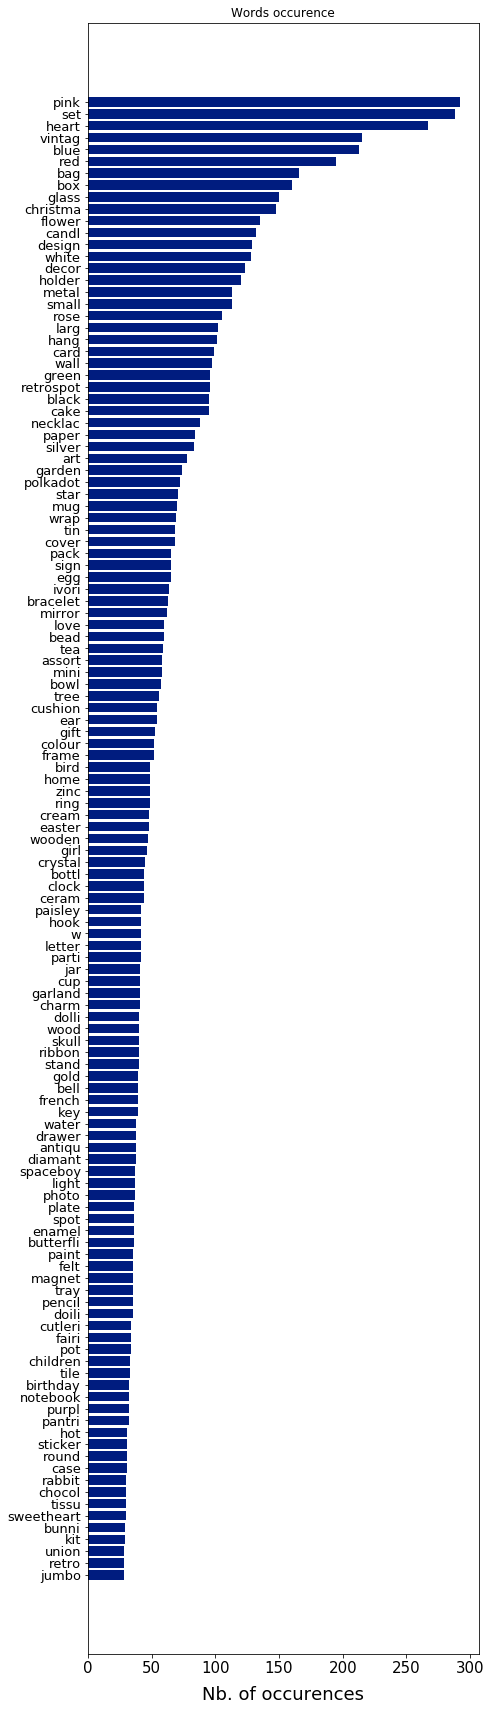

In [63]:

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 30))
y_axis = [i[1] for i in sorted_keywords[:125]]
x_axis = [k for k,i in enumerate(sorted_keywords[:125])]
x_label = [i[0] for i in sorted_keywords[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence")
plt.show()

### Product description word cloud

In [64]:
keywords=(" ").join(tokens)
len(keywords)

93914

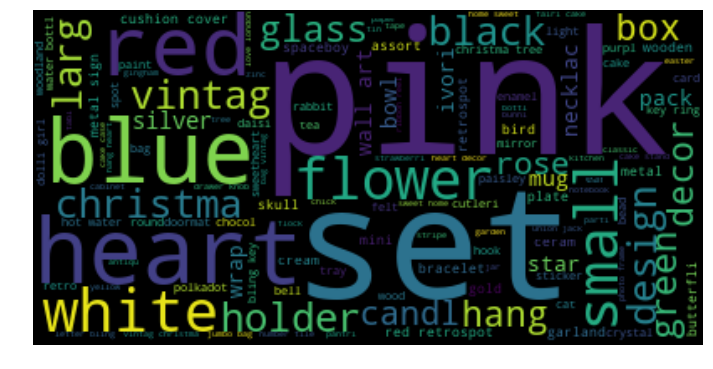

In [65]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(keywords)

# Display the generated image:
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")
plt.show()

Some of the most common words are colors, lets look at them

In [66]:
matching_pink = [s for s in descriptions if 'pink' in s]
matching_pink[:5]

['alarm clock bakelike pink',
 'jumbo bag pink polkadot',
 'pack of 60 pink paisley cake cases',
 'jumbo bag pink vintage paisley',
 'girly pink tool set']

Not much information in these words, removing colors from descriptions

In [67]:
for item in ['pink','blue','white','red','black']:
    while item in tokens: tokens.remove(item)  

In [68]:
keywords=(" ").join(tokens)

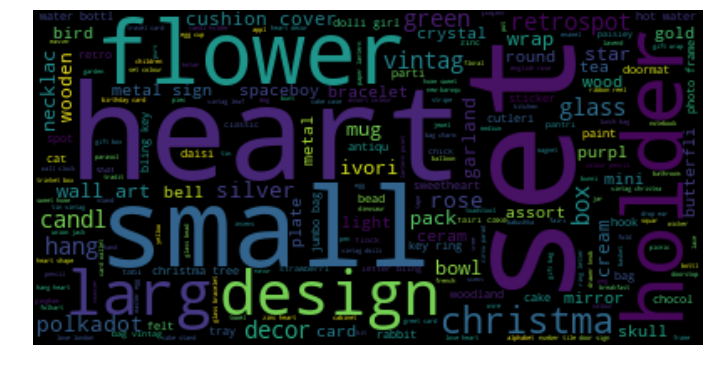

In [69]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(keywords)

# Display the generated image:
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")
plt.show()

### Creating keyword feaures

List of keywords, only occurances above 10

In [70]:
list_keywords = {}                       
value=0
for k in sorted_keywords:
    if k[1]<10: break
    
    list_keywords.update( {k[0] : value} )
    value+=1

In [71]:
X = descriptions
 
# settings that you use for count vectorizer will go here
tfidf_vectorizer=TfidfVectorizer(use_idf=True, lowercase=True, 
                                 stop_words="english",  
                                vocabulary=list_keywords)
 
# just send in all your docs here
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(X)

In [72]:
#Descriptions vectorized

DV= pd.DataFrame(tfidf_vectorizer_vectors.todense(), index=X, columns=tfidf_vectorizer.get_feature_names())

In [73]:
DV.shape

(3877, 330)

### Clustering description keywords

#### SVD

In [74]:
svd = TruncatedSVD(n_components = 200)
SVD_DV = svd.fit_transform(DV)
normalizer = Normalizer(copy=False)
#SVD_DV = normalizer.fit_transform(SVD_DV)
print("TF_IDF_embedded :", SVD_DV.shape, "of", SVD_DV.dtype)

TF_IDF_embedded : (3877, 200) of float64


In [75]:
explained_variance=svd.explained_variance_
explained_variance_ratio=svd.explained_variance_ratio_

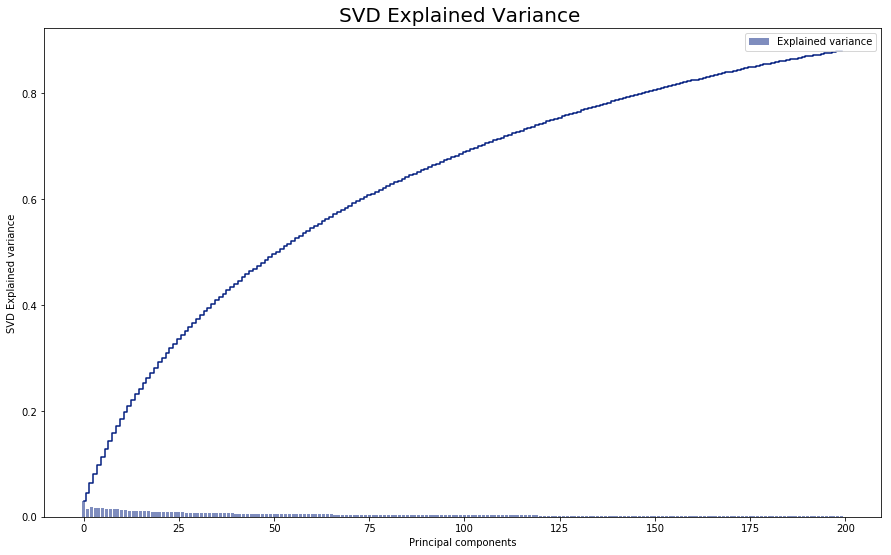

In [76]:
plt.figure(figsize=(15,9))
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center', label='Explained variance')
plt.ylabel('SVD Explained variance')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title("SVD Explained Variance ", fontsize=20)
plt.step(range(len(explained_variance)), np.cumsum(explained_variance), where='mid',label='cumulative explained variance')
plt.show()

### PCA

In [77]:
covar_matrix = PCA(n_components = 200) 

In [78]:
covar_matrix.fit(DV)                              
var = covar_matrix.explained_variance_ratio_ 
cml_var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)


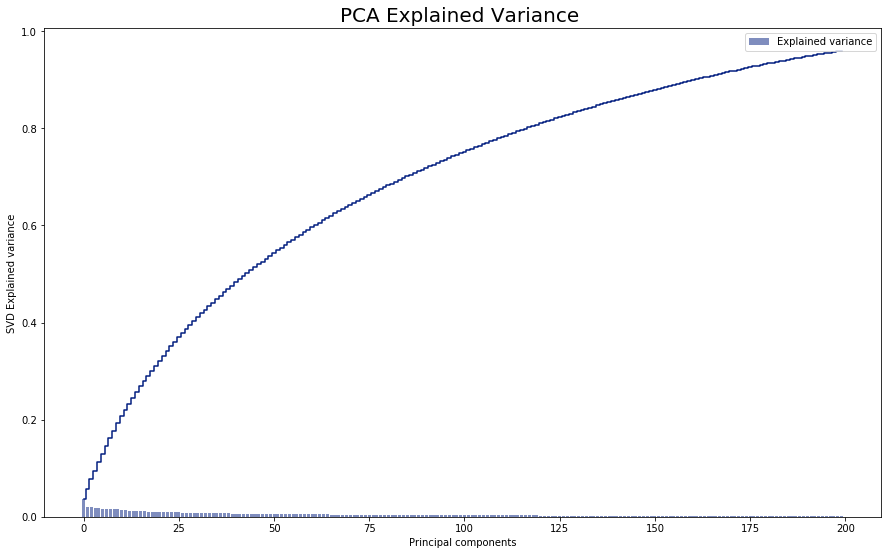

In [79]:
plt.figure(figsize=(15,9))
plt.bar(range(len(var)), var, alpha=0.5, align='center', label='Explained variance')
plt.ylabel('SVD Explained variance')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title("PCA Explained Variance ", fontsize=20)
plt.step(range(len(var)), np.cumsum(var), where='mid',label='cumulative explained variance')
plt.show() 

We select 50 components

In [80]:
n_components=50

In [81]:
DV_pca = PCA(n_components)                   
matrix_9D = DV_pca.fit_transform(DV)
DV_reduced = pd.DataFrame(matrix_9D)              #dataframe after PCA

PCA preserves higher variance than SVD, we choose PCA

In [82]:
DV_reduced.shape

(3877, 50)

### KMeans clustering of description keywords

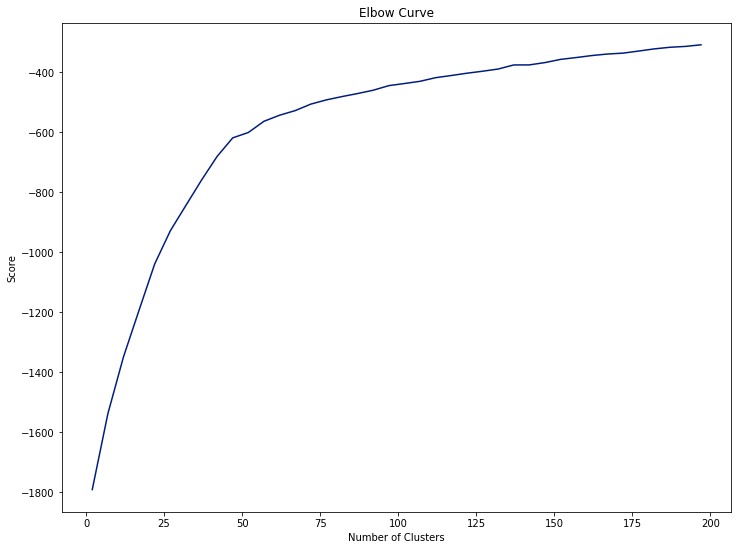

In [83]:
from sklearn.cluster import KMeans

#Elbow method is used to represnt that. 
Nc = range(2, 200, 5)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(DV_reduced).score(DV_reduced) for i in range(len(kmeans))]
plt.figure(figsize=(12,9))
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

We use Elbow method select 75 clusters to form description features

In [84]:
n_clusters = 50

Text(0.5,1,'ACP with 135 clusters')

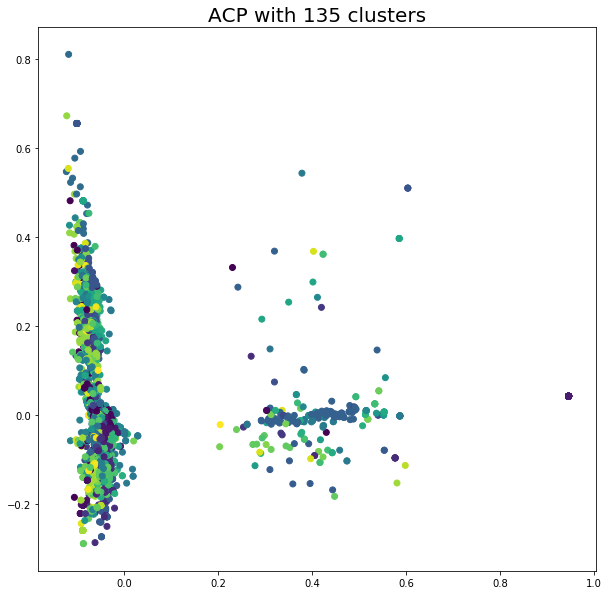

In [85]:
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=5, random_state=0)
proj = kmeans.fit_transform(DV_reduced)
clusters = kmeans.predict(DV_reduced)
plt.figure(figsize=(10,10))

plt.scatter(DV_reduced.iloc[:, 0], DV_reduced.iloc[:,1], c=clusters)
plt.title("ACP with 135 clusters", fontsize="20")

#### TSNE visualization of keyword clusters

In [86]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(DV_reduced)

In [87]:
DV_reduced.head(1)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.106183,0.405852,-0.525761,0.111754,0.123787,0.073304,-0.021788,0.006662,-0.055048,0.385266,...,-0.018165,-0.083612,-0.0049,-0.015162,-0.003495,-0.00692,-0.011037,0.014062,0.022186,-0.00263


<function matplotlib.pyplot.show(*args, **kw)>

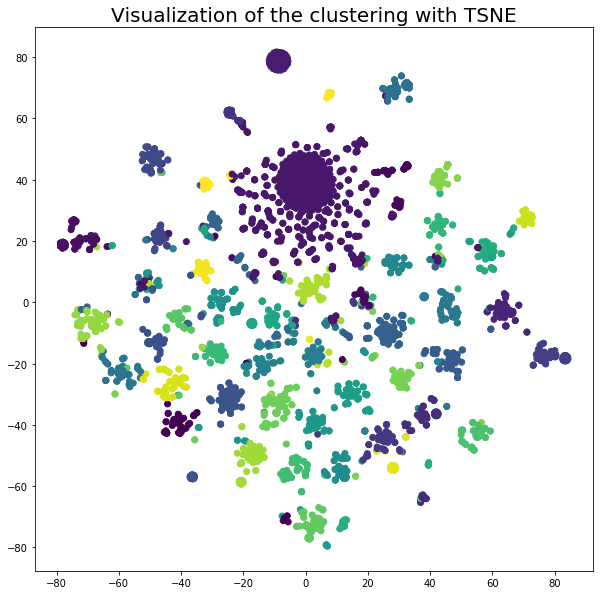

In [88]:
plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="20")
plt.show

# 4-Categorizing customers based on RMF and products purchased

In [89]:
dict_article_to_cluster = {article : cluster for article, cluster in zip(X, clusters)}

### Intermediate datasets

In [90]:
ID_RFM=rfm_df                           #r m s vs. cosumer ID
ID_RFM.head(3)        

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,2,182,8.368925
12348.0,75,31,7.494564
12349.0,18,73,7.472245


In [91]:
cluster = data['Description'].apply(lambda x : dict_article_to_cluster[x])

In [92]:
df2 = pd.get_dummies(cluster, prefix="Cluster").mul(data["TotalPrice"], 0)
df2 = pd.concat([data['InvoiceNo'], df2], axis=1)
Invoice_clusters = df2.groupby('InvoiceNo').sum()            #Clusters vs. Invoice

In [93]:
Invoice_clusters.head(3)

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,...,Cluster_40,Cluster_41,Cluster_42,Cluster_43,Cluster_44,Cluster_45,Cluster_46,Cluster_47,Cluster_48,Cluster_49
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.00,0.0,42.34,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,40.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
536366,0.0,0.00,0.0,11.10,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
536367,0.0,71.93,0.0,87.00,0.0,0.0,0.0,0.0,92.05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.85


In [94]:
ID_Invoice=data[['CustomerID','InvoiceNo']]         #Invoices vs. ID

In [95]:
ID_Invoice.head(3)

,CustomerID,InvoiceNo
0,17850.0,536365
1,17850.0,536365
2,17850.0,536365


In [96]:
Invoice_clustersID = Invoice_clusters.merge(ID_Invoice,left_on='InvoiceNo',right_on='InvoiceNo')

In [97]:
ID_Clusters=Invoice_clustersID.groupby(['CustomerID']).sum()

### Final customer ID dataset consisting of RMF features and product category features

In [98]:
ID_Final = ID_Clusters.merge(ID_RFM,left_on='CustomerID',right_on='CustomerID').reset_index()

In [99]:
ID_Final.head(3)

,CustomerID,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,...,Cluster_43,Cluster_44,Cluster_45,Cluster_46,Cluster_47,Cluster_48,Cluster_49,Recency,Frequency,Monetary
0,12347.0,0.0,2346.24,1018.80,35348.97,460.35,2613.60,297.0,0.0,2808.0,...,0.0,0.0,465.00,0.0,1436.7,12156.6,0.00,2,182,8.368925
1,12348.0,0.0,0.00,0.00,7816.00,0.00,4688.88,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,75,31,7.494564
2,12349.0,912.5,0.00,1973.92,38700.95,3214.92,0.00,7102.9,0.0,4927.5,...,0.0,0.0,8492.82,0.0,0.0,0.0,4524.54,18,73,7.472245


### Clustering customer ID dataset

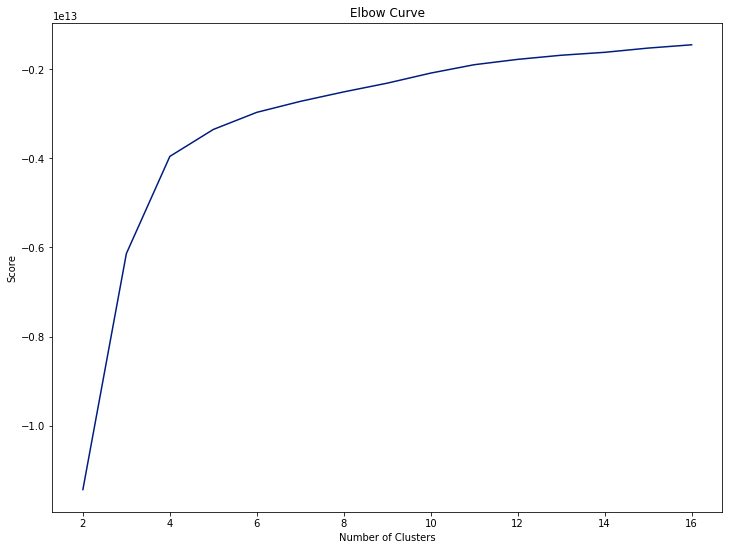

In [100]:
Nc = range(2, 17, 1)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(ID_Final).score(ID_Final) for i in range(len(kmeans))]
plt.figure(figsize=(12,9))
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

We use Elbow method and select 5 customer clusters

In [101]:
num_customer_clusters =5

In [102]:
kmeans = KMeans(init='k-means++', n_clusters = num_customer_clusters, n_init=10, random_state=0)
proj = kmeans.fit_transform(ID_Final)
customer_clusters = kmeans.predict(ID_Final)


In [103]:
ID_Final['cluster_number'] = pd.Series(customer_clusters, index=ID_Final.index)

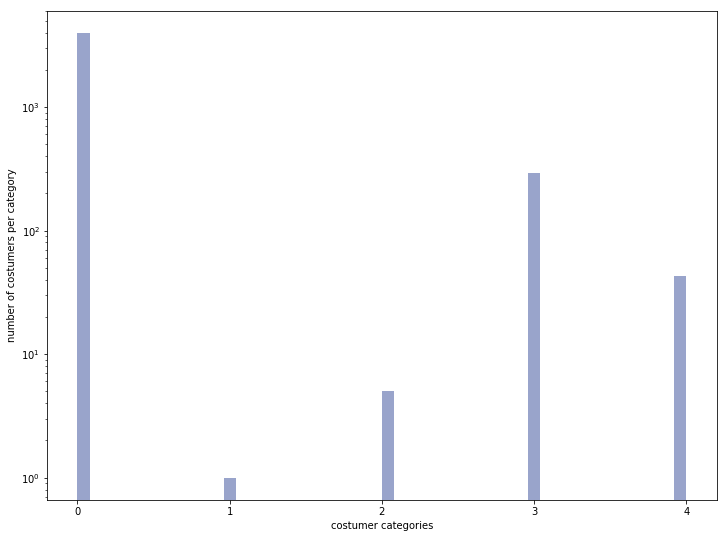

In [104]:
plt.figure(figsize=(12,9))
plt.yscale('log')
sns.distplot(customer_clusters, kde=False)
plt.xticks(range(0,5))
plt.ylabel('number of customers per category')
plt.xlabel('customer categories')
plt.show()

#### Removing outliers for better clustering

In [105]:
ID_Final[ID_Final.cluster_number==1]

,CustomerID,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,...,Cluster_44,Cluster_45,Cluster_46,Cluster_47,Cluster_48,Cluster_49,Recency,Frequency,Monetary,cluster_number
1287,14096.0,444816.05,183468.58,552941.84,9820337.2,1089136.21,392992.6,626868.11,39923.67,715928.8,...,29347.62,241399.39,0.0,274584.39,163544.31,861268.16,4,5111,11.08469,1


In [106]:
ID_Final=ID_Final.drop(index=1287, inplace=False)
ID_Final=ID_Final.reset_index(drop=True)

In [107]:
ID_Final[ID_Final.index==1287]

,CustomerID,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,...,Cluster_44,Cluster_45,Cluster_46,Cluster_47,Cluster_48,Cluster_49,Recency,Frequency,Monetary,cluster_number
1287,14098.0,0.0,353.85,0.0,713.16,173.25,196.56,0.0,0.0,107.1,...,0.0,0.0,0.0,0.0,0.0,0.0,36,21,4.999574,0


#### Clustering after outlier removal

In [108]:
ID_Final=ID_Final.drop(columns='cluster_number')

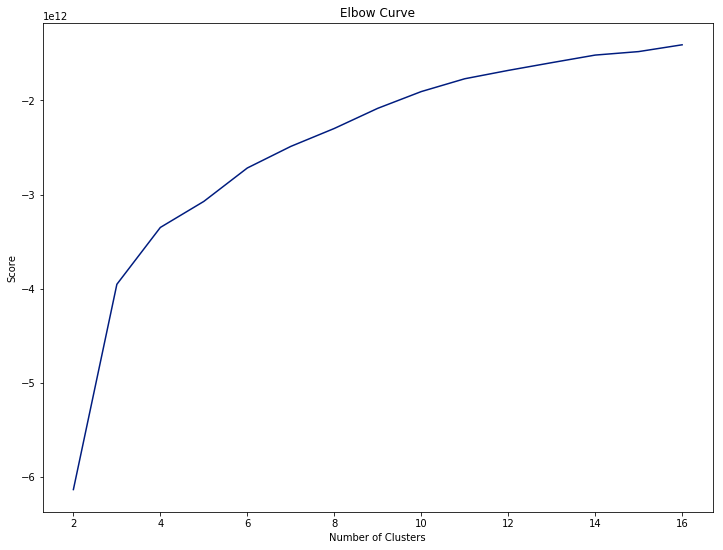

In [109]:
from sklearn.cluster import KMeans
# get right number of cluster for K-means so we neeed to loop from 1 to 20 number of cluster and check score.
#Elbow method is used to represnt that. 
Nc = range(2, 17, 1)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(ID_Final).score(ID_Final) for i in range(len(kmeans))]
plt.figure(figsize=(12,9))
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [110]:
num_customer_clusters =5

In [111]:
kmeans = KMeans(init='k-means++', n_clusters = num_customer_clusters, n_init=10, random_state=0)
proj = kmeans.fit_transform(ID_Final)
customer_clusters = kmeans.predict(ID_Final)

In [112]:
ID_Final['cluster_number'] = pd.Series(customer_clusters, index=ID_Final.index)

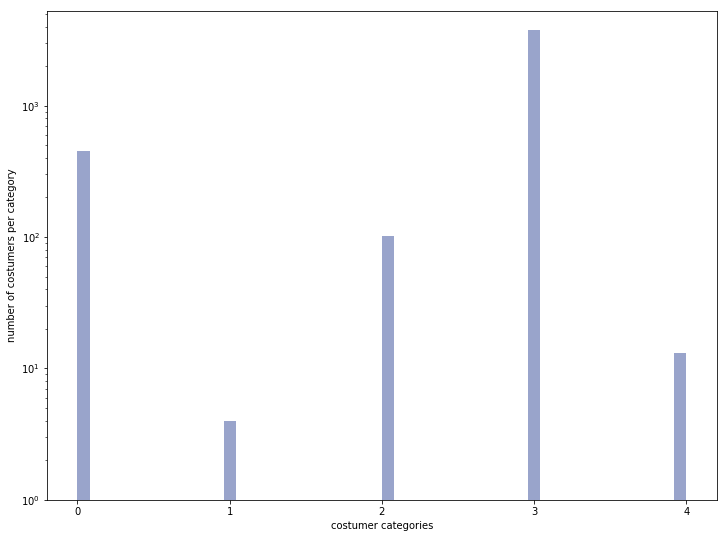

In [113]:
plt.figure(figsize=(12,9))
plt.yscale('log')
sns.distplot(customer_clusters, kde=False)
plt.xticks(range(0,5))
plt.ylabel('number of customers per category')
plt.xlabel('customer categories')
plt.ylim(bottom=1)
plt.show()

#### TSNE visualization of customer clusters

In [114]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(ID_Final)


<function matplotlib.pyplot.show(*args, **kw)>

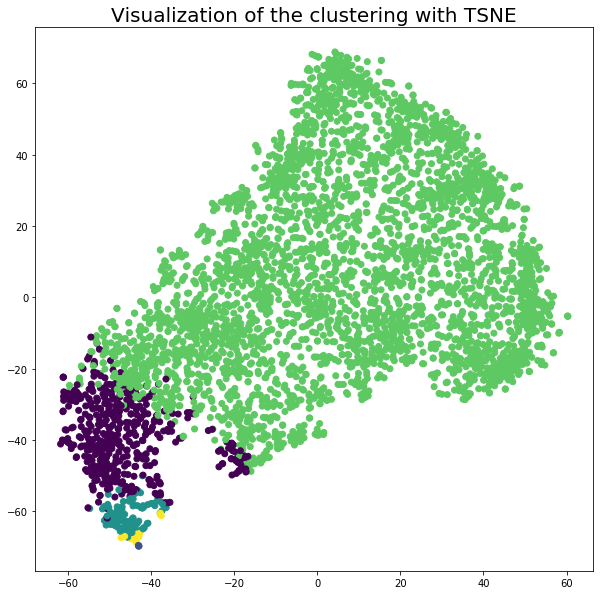

In [115]:
plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=customer_clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="20")

plt.show

### Visualizing customer clusters

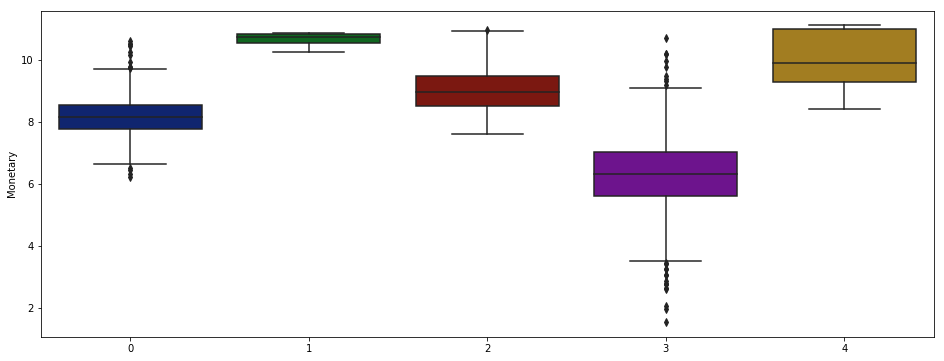

In [116]:
plt.figure(figsize=(16, 6))
sns.boxplot(customer_clusters,ID_Final.Monetary)

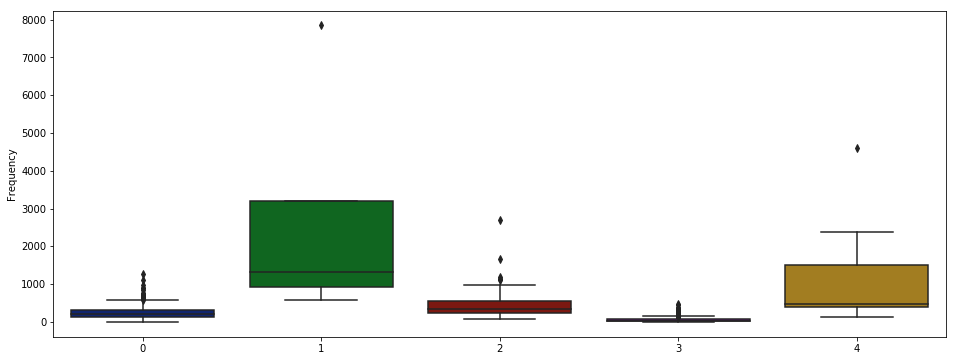

In [117]:
plt.figure(figsize=(16, 6))
sns.boxplot(customer_clusters,ID_Final.Frequency)

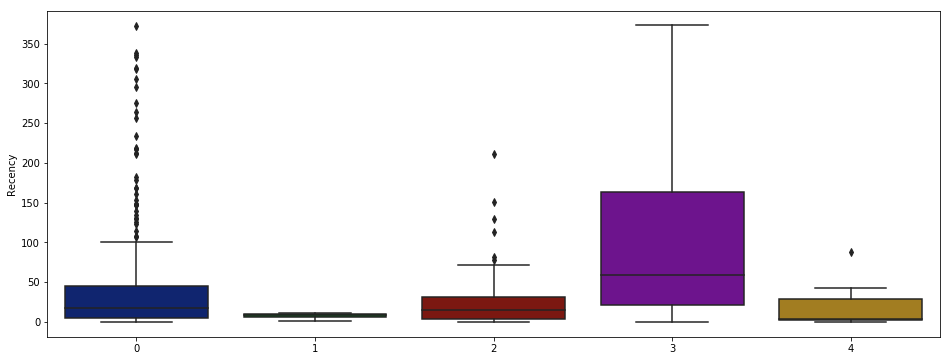

In [118]:
plt.figure(figsize=(16, 6))
sns.boxplot(customer_clusters,ID_Final.Recency)

In [119]:
ID_Final.head()

,CustomerID,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,...,Cluster_44,Cluster_45,Cluster_46,Cluster_47,Cluster_48,Cluster_49,Recency,Frequency,Monetary,cluster_number
0,12347.0,0.0,2346.24,1018.80,35348.97,460.35,2613.60,297.0,0.0,2808.0,...,0.0,465.00,0.0,1436.7,12156.6,0.00,2,182,8.368925,0
1,12348.0,0.0,0.00,0.00,7816.00,0.00,4688.88,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,75,31,7.494564,3
2,12349.0,912.5,0.00,1973.92,38700.95,3214.92,0.00,7102.9,0.0,4927.5,...,0.0,8492.82,0.0,0.0,0.0,4524.54,18,73,7.472245,0
3,12350.0,0.0,0.00,1152.60,1844.50,0.00,0.00,0.0,0.0,0.0,...,0.0,673.20,0.0,255.0,0.0,0.00,310,17,5.815324,3
4,12352.0,796.5,530.25,404.10,12411.20,270.00,0.00,488.5,0.0,576.0,...,0.0,0.00,0.0,225.0,0.0,564.75,36,85,7.826858,3


In [120]:
ID_Final.to_csv("final_customer_dataset.csv",index=False)

### Classification algorithms to predict new customer cluster

In [121]:
new_df = pd.read_csv("final_customer_dataset.csv")


In [122]:
new_df.head(5)


,CustomerID,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,...,Cluster_44,Cluster_45,Cluster_46,Cluster_47,Cluster_48,Cluster_49,Recency,Frequency,Monetary,cluster_number
0,12347.0,0.0,2346.24,1018.80,35348.97,460.35,2613.60,297.0,0.0,2808.0,...,0.0,465.00,0.0,1436.7,12156.6,0.00,2,182,8.368925,0
1,12348.0,0.0,0.00,0.00,7816.00,0.00,4688.88,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,75,31,7.494564,3
2,12349.0,912.5,0.00,1973.92,38700.95,3214.92,0.00,7102.9,0.0,4927.5,...,0.0,8492.82,0.0,0.0,0.0,4524.54,18,73,7.472245,0
3,12350.0,0.0,0.00,1152.60,1844.50,0.00,0.00,0.0,0.0,0.0,...,0.0,673.20,0.0,255.0,0.0,0.00,310,17,5.815324,3
4,12352.0,796.5,530.25,404.10,12411.20,270.00,0.00,488.5,0.0,576.0,...,0.0,0.00,0.0,225.0,0.0,564.75,36,85,7.826858,3


In [123]:
X = new_df.drop(columns=['CustomerID', 'cluster_number']) 
y = new_df['cluster_number'].values

In [124]:
scaler = StandardScaler() # create scaler object

X_scaled = scaler.fit_transform(X)

#### Splitting data into training and test sets

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size = 0.2,random_state = 0) # Do 80/20 split

#### Logistic regression

In [126]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("LogisticRegression_classifier accuracy:", (lr.score(X_test, y_test))*100)

LogisticRegression_classifier accuracy: 95.03464203233256


#### SGD

In [127]:
SGD = SGDClassifier()
SGD.fit(X_train, y_train)
print("SGDClassifier accuracy:", (SGD.score(X_test, y_test))*100)

SGDClassifier accuracy: 92.72517321016166


#### SVC

In [128]:
svc = LinearSVC()
svc.fit(X_train, y_train)
print("LinearSVC accuracy:", (svc.score(X_test, y_test))*100)

LinearSVC accuracy: 96.30484988452656


#### Random Forest

In [129]:
rfc=RandomForestClassifier(random_state=0, n_estimators = 1000)

In [130]:
param_grid = { 
    'n_estimators' : [100, 500, 1000],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'max_depth' : [4, 6],
    'criterion' :['gini', 'entropy']
}

In [131]:
CV_rfc_biased = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, verbose=0, n_jobs=-1, scoring='accuracy') 
CV_rfc_biased.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 500, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 6], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [132]:
CV_rfc_biased.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 500}

In [133]:
rfc=RandomForestClassifier(random_state=0, n_estimators = 500, criterion='gini', max_depth=6, max_features='auto')

In [134]:
rfc.fit(X_train, y_train)
print("Accuracy for Random Forest Classifier:", (rfc.score(X_test, y_test)*100))

Accuracy for Random Forest Classifier: 97.45958429561202


#### Stacking classifiers

In [135]:
clf1 = lr
clf2 = rfc
clf3 = svc

meta = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=meta)

params = {
          'meta_classifier__C': [0.01 , 0.1]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X_train, y_train)



print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'meta_classifier__C': 0.1}
Accuracy: 0.97
